# Winsorizer
Winzorizer finds maximum and minimum values following a Gaussian or skewed distribution as indicated. It can also cap the right, left or both ends of the distribution.

The Winsorizer() caps maximum and / or minimum values of a variable.

The Winsorizer() works only with numerical variables. A list of variables can
be indicated. Alternatively, the Winsorizer() will select all numerical
variables in the train set.

The Winsorizer() first calculates the capping values at the end of the
distribution. The values are determined using:

- a Gaussian approximation,
- the inter-quantile range proximity rule (IQR)
- percentiles.


### Example

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.outliers import Winsorizer

In [2]:
def load_titanic():
    # Load dataset from OpenML
    data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    
    # Replace '?' with NaN
    data = data.replace('?', np.nan)
    
    # Extract first letter of cabin
    data['cabin'] = data['cabin'].astype(str).str[0]
    
    # Convert 'pclass' to categorical
    data['pclass'] = data['pclass'].astype('O')
    
    # Ensure 'age' contains only numeric data by coercing errors to NaN
    data['age'] = pd.to_numeric(data['age'], errors='coerce')
    
    # Fill missing values in 'age' with the median age
    data['age'].fillna(data['age'].median(), inplace=True)
    
    # Ensure 'fare' contains only numeric data by coercing errors to NaN
    data['fare'] = pd.to_numeric(data['fare'], errors='coerce')
    
    # Fill missing values in 'fare' with the median fare
    data['fare'].fillna(data['fare'].median(), inplace=True)
    
    # Fill missing values in 'embarked' with 'C'
    data['embarked'].fillna('C', inplace=True)
    
    # Drop irrelevant columns
    data.drop(labels=['name', 'ticket'], axis=1, inplace=True)
    
    return data

# Load the data
data = load_titanic()

# Display the first few rows of the cleaned data
data.head()

C:\Users\devanshu.tayal\AppData\Local\Temp\ipykernel_16072\2003671112.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['age'].fillna(data['age'].median(), inplace=True)
C:\Users\devanshu.tayal\AppData\Local\Temp\ipykernel_16072\2003671112.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,home.dest
0,1,1,female,29.0000,0,0,211.3375,B,S,2,NaN,"St Louis, MO"
1,1,1,male,0.9167,1,2,151.5500,C,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,female,2.0000,1,2,151.5500,C,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,male,30.0000,1,2,151.5500,C,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,female,25.0000,1,2,151.5500,C,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# To plot histogram of given numerical feature


def plot_hist(data, col):
    plt.figure(figsize=(8, 5))
    plt.hist(data[col], bins=30)
    plt.title("Distribution of "+col)
    return plt.show()

In [4]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data.drop('survived', axis=1),
                                                    data['survived'],
                                                    test_size=0.3,
                                                    random_state=0)

print("train data:", X_train.shape)
print("test data:", X_test.shape)

train data: (916, 11)
test data: (393, 11)


In [5]:
# let's find out the maximum Age and maximum Fare in the titanic

print("Max age:", data.age.max())
print("Max fare:", data.fare.max())

Max age: 80.0
Max fare: 512.3292


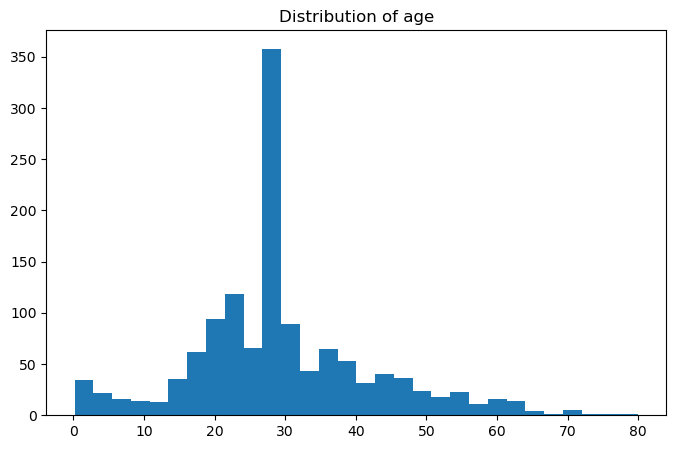

In [6]:
# Histogram of age feature before capping outliers
plot_hist(data, 'age')

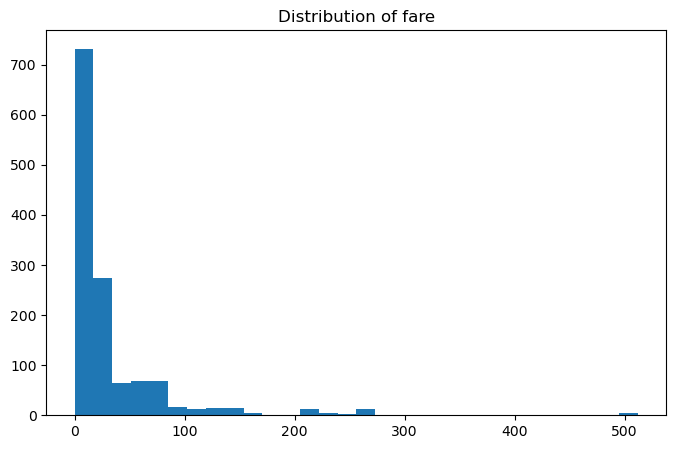

In [7]:
# Histogram of fare feature before capping outliers
plot_hist(data, 'fare')

### Capping : Gaussian

Gaussian limits:
+ right tail: mean + 3* std
+ left tail: mean - 3* std


In [8]:
'''Parameters
----------
capping_method : str, default=gaussian

    Desired capping method. Can take 'gaussian', 'iqr' or 'quantiles'.

tail : str, default=right

    Whether to cap outliers on the right, left or both tails of the distribution.
    Can take 'left', 'right' or 'both'.

fold: int or float, default=3

    How far out to to place the capping values. The number that will multiply
    the std or IQR to calculate the capping values. Recommended values, 2
    or 3 for the gaussian approximation, or 1.5 or 3 for the IQR proximity
    rule.

variables: list, default=None
  
missing_values: string, default='raise'

    Indicates if missing values should be ignored or raised.
'''
# capping at right tail using gaussian capping method
capper = Winsorizer(
    capping_method='gaussian', tail='right', fold=3, variables=['age', 'fare'])

# fitting winsorizer object to training data
capper.fit(X_train)

Winsorizer(fold=3, variables=['age', 'fare'])

In [9]:
# here we can find the maximum caps allowed
capper.right_tail_caps_

{'age': 67.46990824959815, 'fare': 174.7039533684667}

In [10]:
# this dictionary is empty, because we selected only right tail
capper.left_tail_caps_

{}

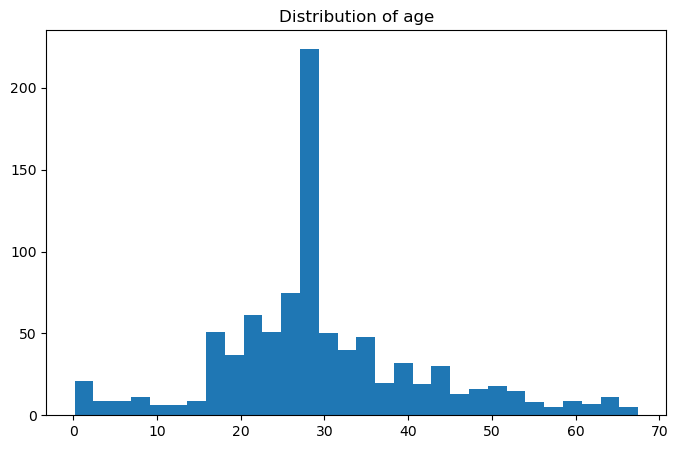

In [11]:
# # Histogram of age feature after capping outliers
plot_hist(capper.transform(X_train), 'age')

In [12]:
# transforming the training and testing data
train_t = capper.transform(X_train)
test_t = capper.transform(X_test)

# let's check the new maximum Age and maximum Fare in the titanic
train_t.age.max(), train_t.fare.max()

(67.46990824959815, 174.7039533684667)

### Gaussian approximation capping, both tails

In [13]:
# Capping the outliers at both tails using gaussian capping method

winsor = Winsorizer(capping_method='gaussian',
                    tail='both', fold=2, variables='fare')
winsor.fit(X_train)

Winsorizer(fold=2, tail='both', variables='fare')

In [14]:
print("Minimum caps :", winsor.left_tail_caps_)

print("Maximum caps :", winsor.right_tail_caps_)

Minimum caps : {'fare': -62.2492183664596}
Maximum caps : {'fare': 127.31331902148143}


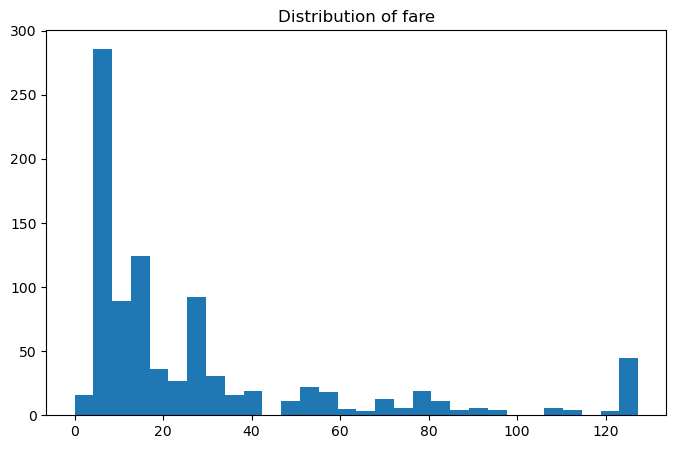

In [15]:
# Histogram of fare feature after capping outliers
plot_hist(winsor.transform(X_train), 'fare')

In [16]:
# transforming the training and testing data
train_t = winsor.transform(X_train)
test_t = winsor.transform(X_test)

print("Max fare:", train_t.fare.max())
print("Min fare:", train_t.fare.min())

Max fare: 127.31331902148143
Min fare: 0.0


### Inter Quartile Range, both tails
**IQR limits:**

- right tail: 75th quantile + 3* IQR
- left tail:  25th quantile - 3* IQR

where IQR is the inter-quartile range: 75th quantile - 25th quantile.


In [17]:
# capping at both tails using iqr capping method
winsor = Winsorizer(capping_method='iqr', tail='both',
                    variables=['age', 'fare'])

winsor.fit(X_train)

Winsorizer(capping_method='iqr', tail='both', variables=['age', 'fare'])

In [18]:
winsor.left_tail_caps_

{'age': 5.0, 'fare': -27.172999999999995}

In [19]:
winsor.right_tail_caps_

{'age': 53.0, 'fare': 66.34379999999999}

In [20]:
# transforming the training and testing data

train_t = winsor.transform(X_train)
test_t = winsor.transform(X_test)

print("Max fare:", train_t.fare.max())
print("Min fare", train_t.fare.min())

Max fare: 66.34379999999999
Min fare 0.0


### percentiles or quantiles:

- right tail: 98th percentile
- left tail:  2nd percentile

In [21]:
# capping at both tails using quantiles capping method
winsor = Winsorizer(capping_method='quantiles', tail='both',
                    fold=0.02, variables=['age', 'fare'])

winsor.fit(X_train)

Winsorizer(capping_method='quantiles', fold=0.02, tail='both',
           variables=['age', 'fare'])

In [22]:
print("Minimum caps :", winsor.left_tail_caps_)

print("Maximum caps :", winsor.right_tail_caps_)

Minimum caps : {'age': 2.0, 'fare': 6.44125}
Maximum caps : {'age': 61.69999999999993, 'fare': 211.5}


In [23]:
# transforming the training and testing data
train_t = winsor.transform(X_train)
test_t = winsor.transform(X_test)

print("Max age:", train_t.age.max())
print("Min age", train_t.age.min())

Max age: 61.69999999999993
Min age 2.0


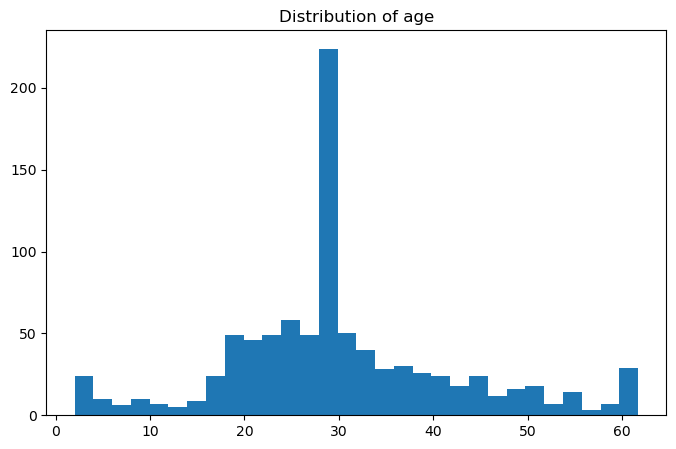

In [24]:
# Histogram of age feature after capping outliers
plot_hist(train_t, 'age')